<a href="https://colab.research.google.com/github/LeahDiskin/DataProject/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
from tensorflow import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools
from pathlib import Path
%matplotlib inline

In [2]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
data=np.load(r"drive/MyDrive/Data Project/data.npz")
# train=np.load(r"drive/MyDrive/Data Project/train.npz")
# validation=np.load(r"drive/MyDrive/Data Project/validation.npz")
# test=np.load(r"drive/MyDrive/Data Project/test.npz")

Mounted at /content/drive


In [3]:
data

In [23]:
batch_size = 32  # The default batch size of keras.
num_classes = 15  # Number of class for the dataset
epochs = 1000
data_augmentation = False

In [24]:
x_train=data['x_train']
y_train=data['y_train']
x_validation=data['x_validation']
y_validation=data['y_validation']
x_test=data['x_test']
y_test=data['y_test']
y_train = np.reshape(y_train, (-1, 1))
y_validation = np.reshape(y_validation, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

In [25]:
print(x_validation.shape)
print(y_validation.shape)

(15000, 32, 32, 3)
(15000, 1)


In [9]:
# for i in y_test:
#   if(i>9):
#     print(i)

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_validation=x_validation.astype('float32')
x_train /= 255
x_test /= 255
x_validation/=255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_validation.shape)
print(y_validation.shape)

(15000, 32, 32, 3)
(15000, 15)


In [27]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [28]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [29]:
y_validation.shape

(15000, 15)

In [30]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_validation, y_validation),
              shuffle=True
              )
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_validation, y_validation),
                                    workers=4)

Not using data augmentation.
Epoch 1/1000
1407/1407 [==============================] - 10s 6ms/step - loss: 2.2035 - accuracy: 0.2742 - val_loss: 1.9367 - val_accuracy: 0.3561
Epoch 2/1000
1407/1407 [==============================] - 9s 7ms/step - loss: 1.8275 - accuracy: 0.3948 - val_loss: 1.6658 - val_accuracy: 0.4456
Epoch 3/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 1.6804 - accuracy: 0.4464 - val_loss: 1.5572 - val_accuracy: 0.4903
Epoch 4/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5825 - accuracy: 0.4800 - val_loss: 1.4875 - val_accuracy: 0.5150
Epoch 5/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 1.5034 - accuracy: 0.5073 - val_loss: 1.4150 - val_accuracy: 0.5377
Epoch 6/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 1.4395 - accuracy: 0.5288 - val_loss: 1.4500 - val_accuracy: 0.5200
Epoch 7/1000
1407/1407 [==============================] - 9s 6ms/step - loss: 1.3825 - accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


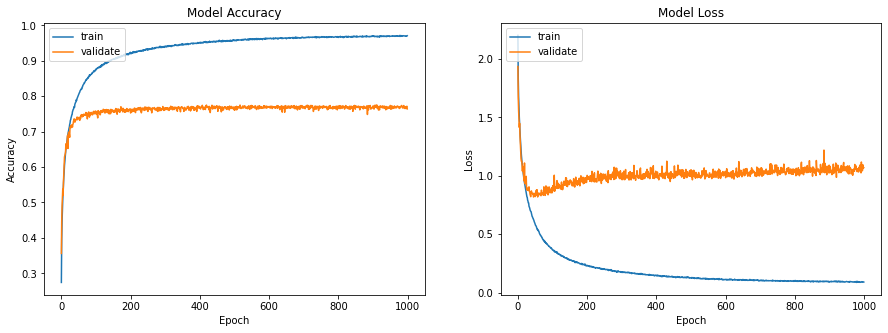

In [31]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [32]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)


469/469 [==============================] - 2s 3ms/step - loss: 1.0928 - accuracy: 0.7625
Test loss: 1.092787504196167
Test accuracy: 0.7624666690826416


In [33]:
print(x_test.shape)

(15000, 32, 32, 3)


In [34]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

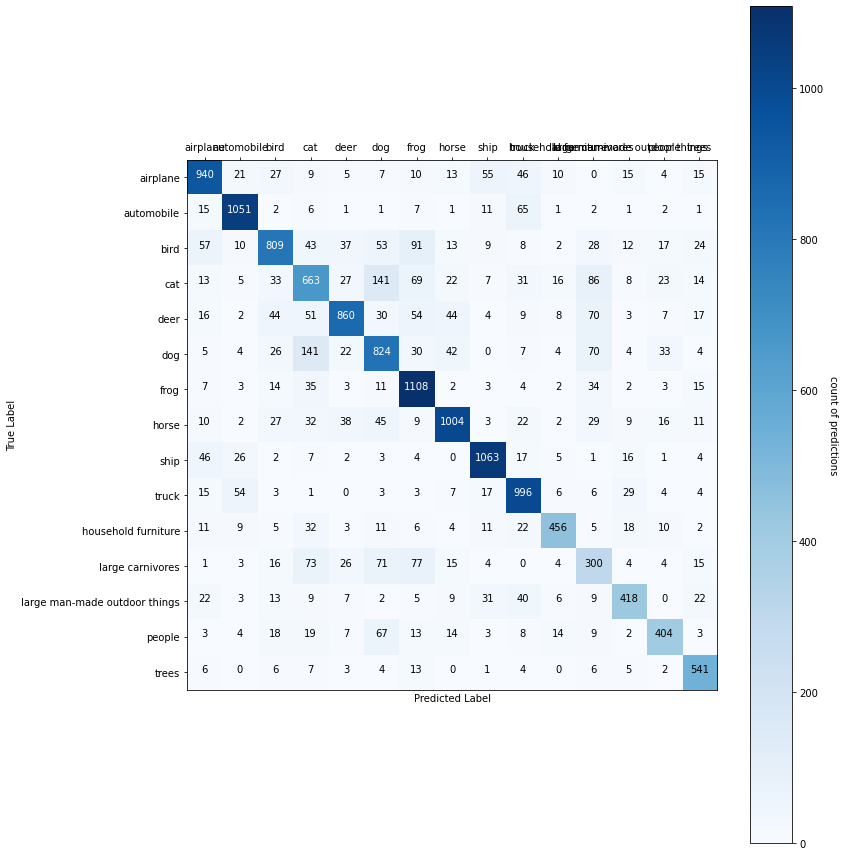

In [35]:
labels=['airplane', 'automobile', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck',
'household furniture','large carnivores',
'large man-made outdoor things',
'people','trees']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [36]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
469/469 [==============================] - 2s 3ms/step - loss: 1.0928 - accuracy: 0.7625
Test loss: 1.092787504196167
Test accuracy: 0.7624666690826416
